In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

from dataset import Dataset
from gen_video import gen_video

## Load Data

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]


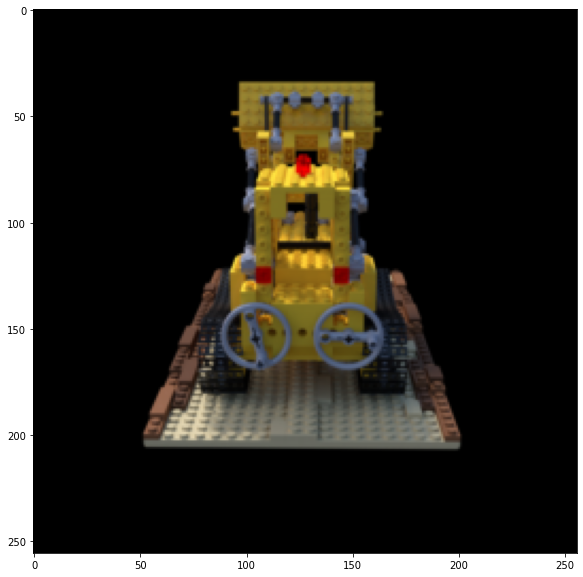

In [2]:
dataset = Dataset('data/nerf_synthetic/lego', 'blender')
H, W = dataset.H, dataset.W
plt.figure(figsize=(10, 10))
plt.imshow(dataset.images[0].permute(1,2,0))

## Raymarching Functions

In [3]:
def ray_box_intersection(rays, bounds):
    """Find intersection of rays with a box
    
    Args:
        rays: Tensor with shape [None, 6]. Each row should be [x, y, z, dx, dy, dz]
        bounds: Tensor with shape [3, 2] representing min and max coords of the box on each axis
    
    Returns normalized nearest intersection coords (or zero for ray misses) and a hit mask
    """
    ro = rays[:, :3]
    rd = rays[:, 3:]
    bounds_expanded = bounds.unsqueeze(0).expand(rays.shape[0], 3, 2)
    signs = (rd < 0).long().unsqueeze(-1)
    near_bounds = bounds_expanded.gather(-1, signs).squeeze(-1)
    t_near = ((near_bounds - ro) / rd).max(dim=-1)[0]
    far_bounds = bounds_expanded.gather(-1, 1-signs).squeeze(-1)
    t_far = ((far_bounds - ro) / rd).min(dim=-1)[0]
    pts = ro + rd * t_near.unsqueeze(-1)
    pts_norm = (pts - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    hit_mask = t_near < t_far
    pts_norm[~hit_mask] = False
    return pts_norm, hit_mask

In [4]:
def raymarch(ro, rd, voxels):
    """Raymarch through a voxel volume
    
    Args:
        ro: Normalized ray origins with shape [None, 3]. Origins should be in the range [0, 1]
        rd: Ray directions with shape [None, 3]
        voxels: Tensor with shape [Nx, Ny, Nz, 4]. The last dimension holds RGB and density.
    
    Returns a [None, 3] tensor holding accumulated RGB for each ray
    """
    # initialization
    vshape = torch.tensor(voxels.shape[:3], device='cuda')
    ro = ro * vshape
    X = ro.clamp(torch.zeros(3, device='cuda'), vshape - 1).long()
    step = rd.sign().long()
    t_delta = (1 / rd).abs()
    t_max = (X + step - ro).abs() * t_delta
    acc_density = torch.zeros(ro.shape[0], 1, device='cuda')
    rgb = torch.zeros_like(ro)
    active = torch.arange(ro.shape[0], device='cuda').long()
    
    vshape = vshape[None, :]
    while active.shape[0] != 0:
        # accumulate color and density
        vi = voxels[X[active].chunk(3, dim=-1)][:, 0]
        density = vi[:, 3, None].relu() # no negative density
        alpha = 1 - torch.exp(-density)
        transmittance = torch.exp(-acc_density[active])
        rgb[active] += vi[:, :3] * alpha * transmittance
        acc_density[active] += density
        
        # step X to next voxel
        step_axis = t_max[active].min(dim=-1)[1]
        X[active, step_axis] += step[active, step_axis]
        t_max[active, step_axis] += t_delta[active, step_axis]
        
        # deactivate if stepped outside bounds
        active_mask = (X[active] >= 0).all(dim=-1).logical_and((X[active] < vshape).all(dim=-1))
        active = active[active_mask]        
    
    return rgb

## Define Model

In [5]:
scene_bds = torch.tensor([
    [-2, 2], [-2, 2], [-2, 2]
], device='cuda').float() * 2.5
voxel_res = [32, 32, 32]

class VoxelModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.voxels = nn.Parameter(
            torch.rand(voxel_res + [4], requires_grad=True, device='cuda'))
        with torch.no_grad():
            self.voxels[..., 3] *= 0.5
    
    def forward(self, rays):
        pts, hit_mask = ray_box_intersection(rays, scene_bds)
        rgb = torch.zeros_like(pts)
        rgb[hit_mask] = raymarch(pts[hit_mask], rays[hit_mask, 3:], self.voxels)
        return rgb

model = VoxelModel()
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
    lambda epoch: max(0.6 ** epoch, 0.01))

losses = []

## Train

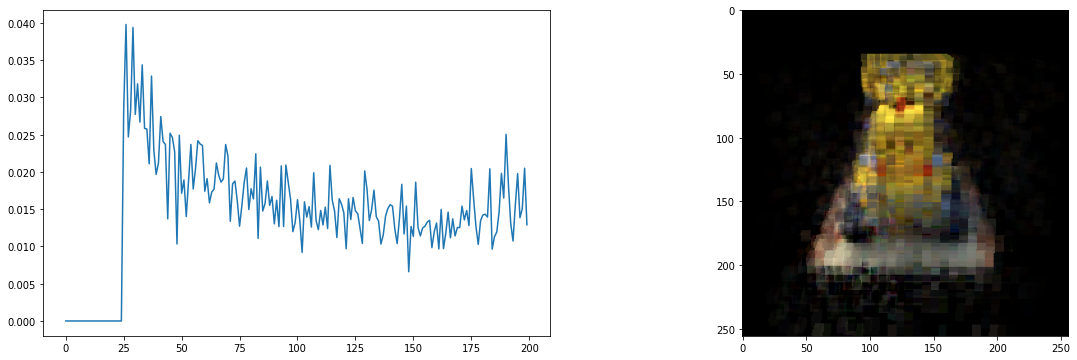

loss: 0.012911573052406311


In [6]:
batch_size = 256

for i in range(2000):
    sel = np.random.choice(dataset.rays.shape[0], batch_size)
    pred = model(dataset.rays[sel])
    loss = loss_fn(pred, dataset.colors[sel])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 10 == 0:
        if len(losses) < 25:
            losses.append(0) # cut off high end of plot
        else:
            losses.append(loss.item())
    if (i + 1) % 200 == 0:
        display.clear_output(wait=True)
        plt.figure(figsize=(20, 6))
        plt.subplot(121)
        plt.plot(losses)
        plt.subplot(122)
        with torch.no_grad():
            x = dataset.rays[:H*W]
            plt.imshow(model(x).detach().clip(0,1).reshape(H, W, 3).cpu())
        plt.show()
    if (i + 1) % 500 == 0:
        scheduler.step()

print(f'loss: {losses[-1]}')

## Test View Interpolation

In [7]:
gen_video(dataset, model, 'videos/out.mp4', duration=5, fps=24)
display.clear_output()
display.display(display.HTML('<video src="videos/out.mp4" controls=true autoplay=true loop=true />'))